In [27]:
# Gerekli kütüphaneleri yükleyin
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import SGD  # SGD optimizer import edildi
from keras import regularizers
from PIL import Image

In [28]:
# Girdi dizini (orijinal dataset)
data_dir_path = 'Alzheimer_s Dataset'

# Çıktı dizini (işlenmiş dataset)
output_dir = 'Processed_Alzheimer_Dataset'

# Görselleri işleyip kaydetme
processed_count = 0
for root, dirs, files in os.walk(data_dir_path):
    for img_file in files:
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, img_file)
            try:
                # Görseli aç
                image = Image.open(img_path)

                # Görseli yeniden boyutlandır ve RGB'ye dönüştür
                image = image.resize((224, 224)).convert('RGB')

                # Çıkış yolunu ayarla
                relative_path = os.path.relpath(root, data_dir_path)  # test/train/validation/sınıf
                save_dir = os.path.join(output_dir, relative_path)

                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)

                # Görseli kaydet
                save_path = os.path.join(save_dir, img_file)
                image.save(save_path)

                # İşlenen görsel sayısını artır
                processed_count += 1
            except Exception as e:
                print(f"{img_path} işlenirken bir hata oluştu: {e}")

# İşlenen görsel sayısını yazdır
print(f"Toplam {processed_count} görsel işlenmiştir.")

Toplam 7110 görsel işlenmiştir.


In [29]:
print(image.mode)  # 'L' ise gri tonlama, 'RGB' ise renkli

RGB


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import numpy as np

# Moderate Demented sınıfı dizini
input_dir = 'Processed_Alzheimer_Dataset/train/ModerateDemented'
output_dir = 'Processed/augmented_moderate_demented'

# Veri artırma ayarları
moderate_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,       # Yatay çevirme tamam
    fill_mode='reflect' 
)

# Yeni görüntüler üretmek
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Her görüntü için veri artırma işlemi
target_count = 1000  # Artırma sonrası hedef görüntü sayısı
current_count = len(os.listdir(input_dir))
images_needed = target_count - current_count

# Her orijinal görüntüden oluşturulacak yeni görüntü sayısı
augment_per_image = images_needed // current_count + 1

# Artırma işlemi
for img_file in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_file)
    img = load_img(img_path, target_size=(224, 224))  # Görüntüyü yükle ve boyutlandır
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Yeni görüntüler oluştur ve kaydet
    i = 0
    for batch in moderate_datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= augment_per_image:
            break

In [31]:
import shutil
import os

# Artırılmış görüntülerin bulunduğu dizin
augmented_data_dir = 'Processed/augmented_moderate_demented'

# Eğitim verilerinin hedef dizini
train_dir = 'Processed_Alzheimer_Dataset/train/ModerateDemented/'

# Artırılmış görüntüleri taşı
for img_file in os.listdir(augmented_data_dir):
    src_path = os.path.join(augmented_data_dir, img_file)
    dst_path = os.path.join(train_dir, img_file)
    shutil.move(src_path, dst_path)


In [53]:
# Eğitim, doğrulama ve test dizinlerinin yolu
train_dir = 'Processed_Alzheimer_Dataset/train/'
val_dir = 'Processed_Alzheimer_Dataset/validation/'
test_dir = 'Processed_Alzheimer_Dataset/test/'

# Eğitim verisi artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalizasyon
    rotation_range=20,            # Dönme
    width_shift_range=0.1,        # Yatay kaydırma
    height_shift_range=0.1,       # Dikey kaydırma
    shear_range=0.1,             # Kesme
    zoom_range=0.1,              # Yakınlaştırma
    horizontal_flip=True,         # Yatay çevirme
    #fill_mode='nearest'           # Eksik pikselleri doldurma
)

# Doğrulama ve test için yalnızca normalizasyon
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim verilerini yükleme
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # Görüntü boyutu
    batch_size=32,               # Mini-batch boyutu
    class_mode='categorical',    # Kategorik sınıflandırma
    color_mode='rgb'             # 3 kanal
)

# Doğrulama verilerini yükleme
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

# Test verilerini yükleme
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 4676 images belonging to 4 classes.
Found 2086 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [58]:
print(train_generator.class_indices)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


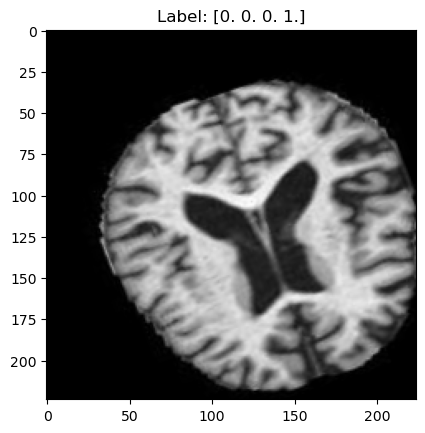

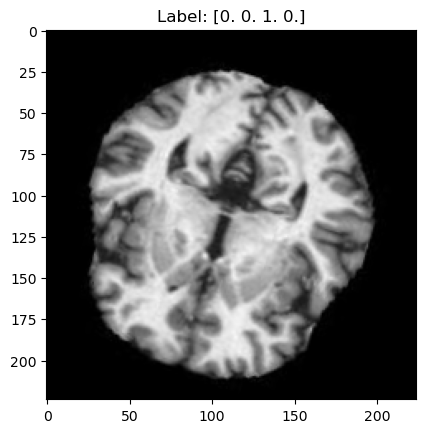

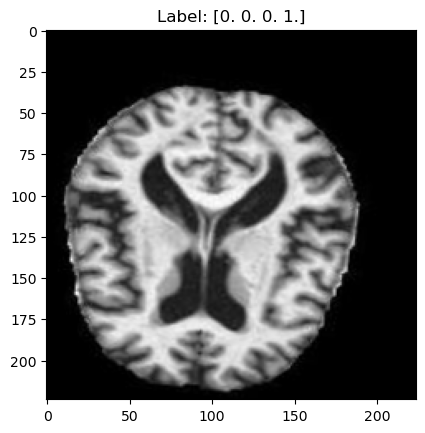

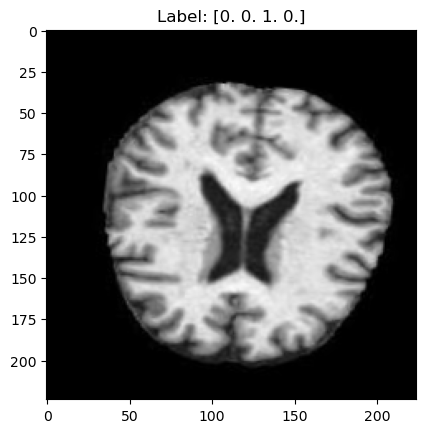

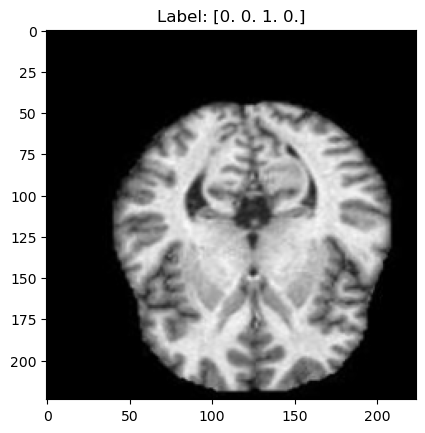

In [42]:
# İlk batch'den örnekler yazdırma
import matplotlib.pyplot as plt
import numpy as np

# Eğitim verisinden bir batch al
images, labels = next(train_generator)

# İlk 5 görseli ve etiketini görselleştir
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()


In [37]:
# Tek bir batch verisi al
x_batch, y_batch = next(train_generator)

# Şekil ve veri türlerini kontrol et
print(x_batch.shape)  
print(y_batch.shape)  

(32, 224, 224, 3)
(32, 4)


In [38]:
# Giriş verisinin türü
print("Görüntü verisinin türü:", type(x_batch))

# Etiketlerin türü
print("Etiket verisinin türü:", type(y_batch))

# Veri türü (Numpy array olmalı)
print("Görüntü verisinin veri türü:", x_batch.dtype)
print("Etiket verisinin veri türü:", y_batch.dtype)


Görüntü verisinin türü: <class 'numpy.ndarray'>
Etiket verisinin türü: <class 'numpy.ndarray'>
Görüntü verisinin veri türü: float32
Etiket verisinin veri türü: float32


In [39]:
# Etiketlerin benzersiz değerlerini kontrol et
print("Benzersiz etiket değerleri:", np.unique(y_batch))


Benzersiz etiket değerleri: [0. 1.]


In [41]:
# İlk 5 etiketin çıktısı
print("İlk 5 etiketin one-hot encoded hali:", y_batch[:5])

# İlk görüntünün minimum ve maksimum değerlerini kontrol etmek için
print("İlk görüntünün minimum değeri:", np.min(x_batch))
print("İlk görüntünün maksimum değeri:", np.max(x_batch))

# Batch boyutunu kontrol etmek için
print("Batch boyutu:", x_batch.shape[0])


İlk 5 etiketin one-hot encoded hali: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
İlk görüntünün minimum değeri: 0.0
İlk görüntünün maksimum değeri: 0.99876785
Batch boyutu: 32


In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Bazı katmanları dondurma
for layer in base_model.layers:
    layer.trainable = True

from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_106"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_21[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [61]:
# Erken durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğit
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 776s 5s/step - accuracy: 0.5436 - loss: 1.0438 - val_accuracy: 0.4463 - val_loss: 1.2603
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 746s 5s/step - accuracy: 0.6948 - loss: 0.6662 - val_accuracy: 0.3150 - val_loss: 1.2468
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 740s 5s/step - accuracy: 0.7263 - loss: 0.5824 - val_accuracy: 0.3854 - val_loss: 1.1211
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 777s 5s/step - accuracy: 0.7008 - loss: 0.6775 - val_accuracy: 0.3150 - val_loss: 1.1783
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 762s 5s/step - accuracy: 0.7544 - loss: 0.5299 - val_accuracy: 0.4482 - val_loss: 1.8389
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.7660 - loss: 0.5124 - val_accuracy: 0.4760 - val_loss: 2.0892
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.7956 - loss: 0.4635 - val_accuracy: 0.4300 - val_loss: 1.0377
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step - accuracy: 0.8018 - loss: 0.4762 - val_accu

In [62]:
# Test seti üzerinde modelin doğruluğunu test et
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 976ms/step - accuracy: 0.4379 - loss: 1.0254
Test Loss: 1.0323086977005005
Test Accuracy: 0.43784207105636597


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step


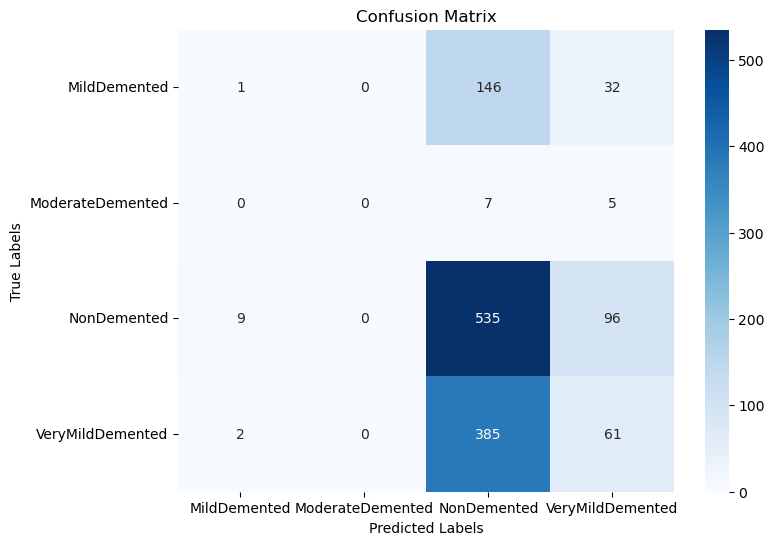

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.08      0.01      0.01       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.84      0.62       640
VeryMildDemented       0.31      0.14      0.19       448

        accuracy                           0.47      1279
       macro avg       0.22      0.24      0.21      1279
    weighted avg       0.37      0.47      0.38      1279



C:\Users\beyza\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beyza\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beyza\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test setindeki gerçek etiketler ve tahmin edilen etiketler
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Konfüzyon matrisi
cm = confusion_matrix(true_labels, predicted_labels)

# Sınıf isimlerini alma
class_names = list(test_generator.class_indices.keys())

# Konfüzyon matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma raporu
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n")
print(report)
